# Loading Data 

## Importing libraries and data files

In [36]:
import os
import tensorflow as tf
import datetime
import sys
from os import path
import numpy as np
import pandas as pd
module_path = os.path.abspath(os.path.join(''))
if module_path not in sys.path:
    sys.path.append(module_path+"\\functions")
    
x_train = pd.read_pickle("x_train.pkl")  
x_test = pd.read_pickle("x_test.pkl")  
y_train = pd.read_pickle("y_train.pkl")  
y_test = pd.read_pickle("y_test.pkl")  


# number of different classes
n_SEPS =  226
n_flares = 17875
n_sample = n_SEPS +n_flares
columns_to_use = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','17','20','21','22','28','39','40',
                       '41','42','43','44','45','46','47','48']
number_of_classes = 2 

In [30]:
module_path

'C:\\Users\\savvra\\OneDrive - KTH\\Github\\GitMLexamples\\machine-learning-examples-SR\\space physics applications\\solar flare forecasting'

## How SEPs & Flares look

Let'see some images though to see how things look 

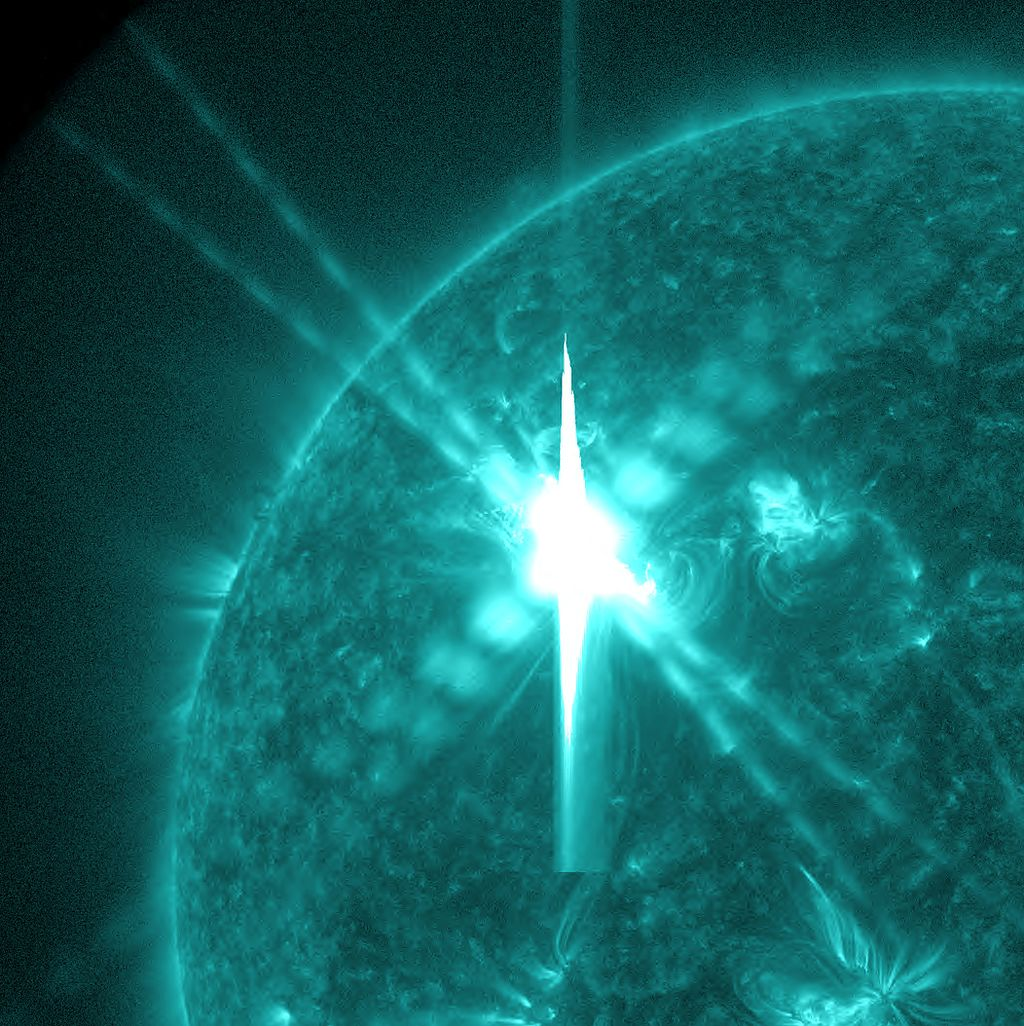

In [7]:
from IPython.display import Image
Image(filename ='X_Class_Solar_Flare_Sends_‘Shockwaves’_on_The_Sun_(6819094556).jpg')

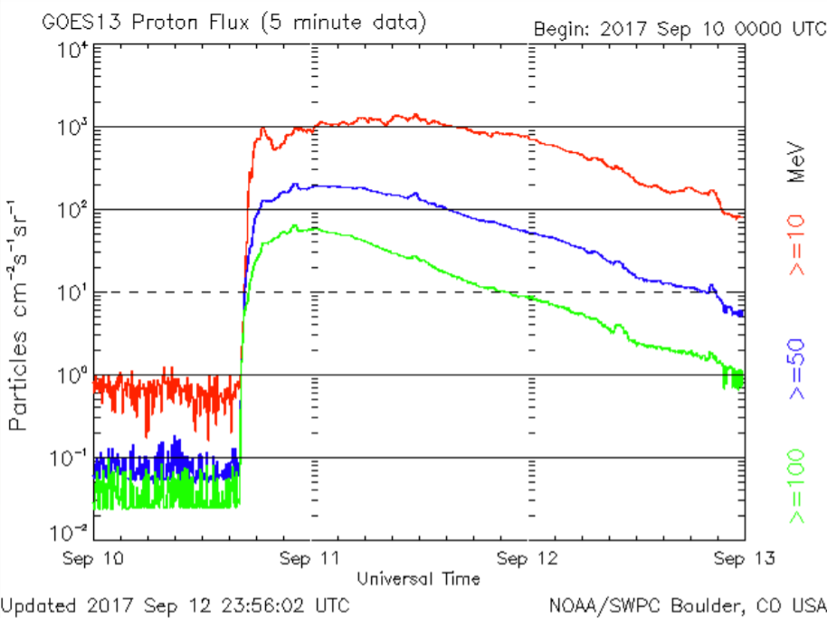

In [8]:
Image(filename='GOES_SEP.png') 


## Split smaller dataset for flares

Since we have way too many flares we should split the training set to have fewer.

In [37]:
number_train_flares = 1500

x_train_SEPS = x_train.loc[y_train['class'] == 1] 
x_train_flares  = x_train.loc[y_train['class'] == 0] 

#Alternative way to calculate remaining flares
#x_train_rescaled_flares2 =  pd.concat([x_train_rescaled_SEPS,x_train_rescaled]).drop_duplicates(keep=False)

#undersampled_flares
x_train_undersampled_flares = x_train_flares.sample(number_train_flares,random_state=2)

#remaining flares to be added to test set
remaining_flares_x = x_train_flares.drop(x_train_undersampled_flares.index.values)
remaining_flares_and_seps_y = y_train.drop(x_train_undersampled_flares.index.values)
remaining_flares_y = remaining_flares_and_seps_y.drop(x_train_SEPS.index.values)

x_test = pd.concat([x_test,remaining_flares_x])
y_test = pd.concat([y_test,remaining_flares_y])

#y_train_rescaled_undersampled_flares = y_train_init.loc[x_train_rescaled_undersampled_flares.index.values]

# Create the new training set
x_train = pd.concat([x_train_undersampled_flares,x_train_SEPS])
y_train= y_train.loc[x_train.index.values]


## Example of Model Setup

Let's setup a model below

In [38]:
import NN_models_SR 
import importlib
importlib.reload(NN_models_SR)
from NN_models_SR import simple_model
from NN_models_SR import deeper_model
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_train_features = x_train[columns_to_use]
x_test_features = x_test[columns_to_use]

nin = len(x_train_features.columns)


SGD_2 = tf.keras.optimizers.SGD(
    learning_rate=0.005, momentum=0.5, nesterov=True
)

optimizer_choice_1 = 'Adam'
optimizer_choise_2 = SGD_2
scaling_factor_loss = 100

scaling_factor = len(y_train[y_train[:,1] ==0])/len(y_train[y_train[:,1] ==1])


model_used = deeper_model(nin,number_of_classes,optimizer_choise_2,scaling_factor)

class_weight_choice = {0: 1,
                1: scaling_factor}

## Example of Training proccedure


Let's now train our model

In [39]:
from tensorflow.keras.callbacks import EarlyStopping

batch_size_choice = round(len(x_train_features))

early_stop = EarlyStopping(monitor='loss' , min_delta=1e-04, patience=50 , verbose=1,
                                   mode ='auto', restore_best_weights= True)

history = model_used.fit(x_train_features, y_train, epochs=1000, batch_size=batch_size_choice, 
                         verbose=2, 
                         callbacks=[early_stop],
                         validation_data = (x_test_features, y_test))
#class_weight=class_weight_choice,

Epoch 1/1000
1/1 - 1s - loss: 1.5147 - acc: 0.5156 - f1_m: 0.5156 - precision_m: 0.5156 - recall_m: 0.5156 - val_loss: 0.7635 - val_acc: 0.2344 - val_f1_m: 0.2337 - val_precision_m: 0.2337 - val_recall_m: 0.2337
Epoch 2/1000
1/1 - 0s - loss: 1.0759 - acc: 0.5819 - f1_m: 0.5819 - precision_m: 0.5819 - recall_m: 0.5819 - val_loss: 0.7795 - val_acc: 0.2031 - val_f1_m: 0.2027 - val_precision_m: 0.2027 - val_recall_m: 0.2027
Epoch 3/1000
1/1 - 0s - loss: 0.9078 - acc: 0.6177 - f1_m: 0.6177 - precision_m: 0.6177 - recall_m: 0.6177 - val_loss: 0.7870 - val_acc: 0.2080 - val_f1_m: 0.2078 - val_precision_m: 0.2078 - val_recall_m: 0.2078
Epoch 4/1000
1/1 - 0s - loss: 0.8285 - acc: 0.6524 - f1_m: 0.6524 - precision_m: 0.6524 - recall_m: 0.6524 - val_loss: 0.7895 - val_acc: 0.2277 - val_f1_m: 0.2273 - val_precision_m: 0.2273 - val_recall_m: 0.2273
Epoch 5/1000
1/1 - 0s - loss: 0.7811 - acc: 0.6770 - f1_m: 0.6770 - precision_m: 0.6770 - recall_m: 0.6770 - val_loss: 0.7890 - val_acc: 0.2481 - val_f1

# Visualziating results (simple metrics)

Let's see the results

In [41]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

predictions = model_used.predict_classes(x_test_features)
y_test_binary = np.argmax(y_test, axis=1)
    
cr = classification_report(y_test_binary, predictions)
cm = confusion_matrix(y_test_binary, predictions)

print(cm)
print("Class 1 accuracy")
print(cm[0,0]/(cm[0,0]+cm[0,1]))

print("Class 2 accuracy")
print(cm[1,1]/(cm[1,0]+cm[1,1]))

print(model_used.summary())
print(cr)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[[15782   593]
 [    4    19]]
Class 1 accuracy
0.9637862595419847
Class 2 accuracy
0.8260869565217391
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 50)                1600      
_________________________________________________________________
batch_normalization_28 (Batc (None, 50)                200       
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 50)                0         
_________________________________________________________________
dense_43 (Den

# Visualziating results (Plots)

Let's see the results

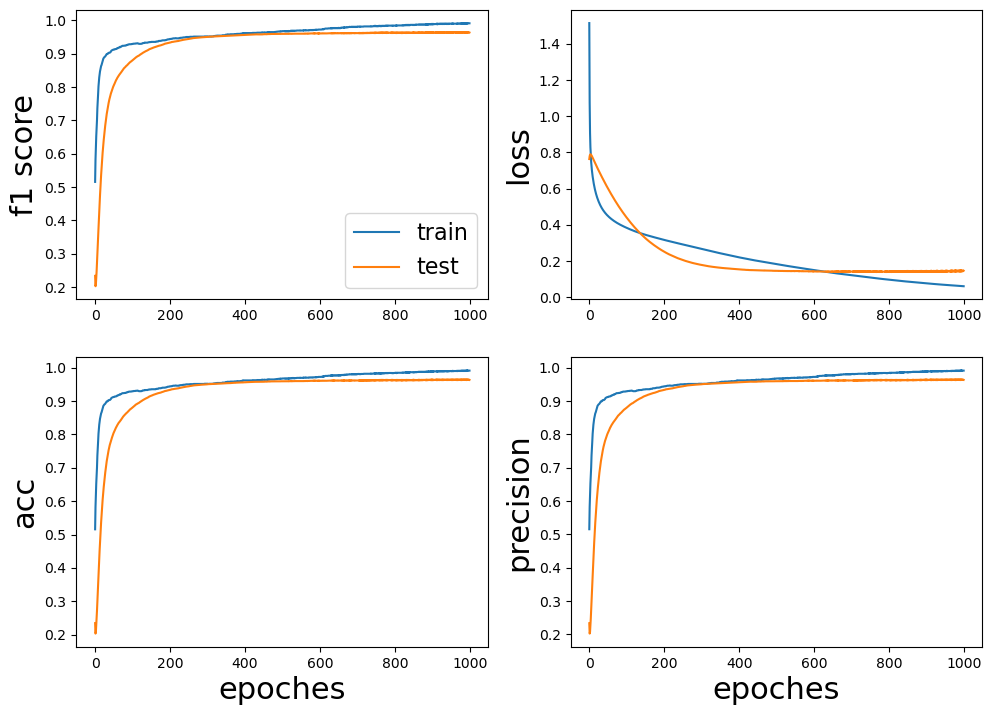

In [42]:
import matplotlib.pyplot as plt

val_f1 = history.history['val_f1_m']
val_loss= history.history['val_loss']
val_acc= history.history['val_acc']
val_prec= history.history['val_precision_m']

train_f1 = history.history['f1_m']
train_loss = history.history['loss']
train_acc = history.history['acc']
train_prec = history.history['precision_m']

plt.figure(figsize=(11.69,8.27))
plt.subplot(2, 2, 1)
plt.plot(train_f1)
plt.plot(val_f1)
plt.ylabel('f1 score',fontsize=22)
plt.legend(['train', 'test'], loc='lower right',fontsize=16)

plt.subplot(2, 2, 2)
plt.plot(train_loss)
plt.plot(val_loss)
plt.ylabel('loss',fontsize=22)

plt.subplot(2, 2, 3)
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('epochs',fontsize=22)
plt.ylabel('acc',fontsize=22)

plt.subplot(2, 2, 4)
plt.plot(train_prec)
plt.plot(val_prec)
plt.xlabel('epochs',fontsize=22)
plt.ylabel('precision',fontsize=22)

plt.show()

